In [5]:
%matplotlib ipympl
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp

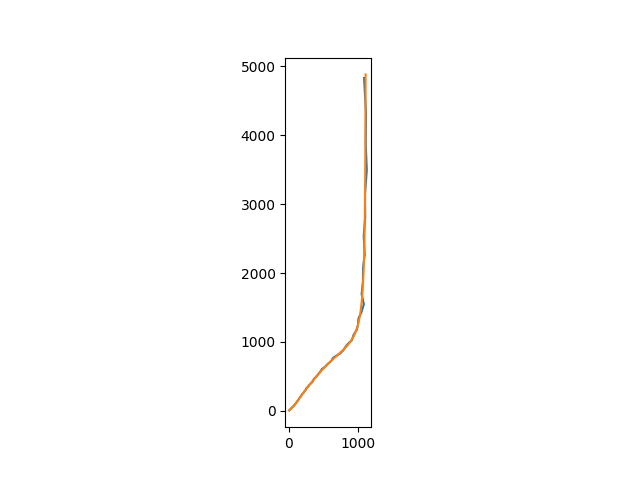

In [6]:
freq_list=np.logspace(-1,4,100)
#parameter for the TLM
Q_dt=6.61e-4
alpha_dt=1

R1_dt=1000
delta1_dt=0.12
R2_dt=2000
delta2_dt=0.17
R3_dt=2.15*194.5


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

cmodel=CustomCircuit(initial_guess=[R1_dt,R1_dt*Q_dt,R2_dt*Q_dt,delta1_dt,alpha_dt],circuit="TLMtwo_1")
zexp=cmodel.predict(frequencies=freq_list)
zexp_noise=np.real(zexp)+np.random.normal(0,0.01,(len(zexp)))*np.real(zexp)+(np.imag(zexp)+np.random.normal(0,0.01,(len(zexp)))*np.imag(zexp))*1j
fig, ax =plt.subplots()
# ax.plot([0,delta1,delta1,1],[R1,R1,R2,R2])
ax.plot(np.real(zexp_noise),-np.imag(zexp_noise))
ax.plot(np.real(zexp),-np.imag(zexp))
ax.set_aspect("equal")

In [7]:
#initial guesses for the TLM
#Double layer Capacitance inside porous electrode
Q=6.61e-4
alpha=1

R1=400
delta1=0.3
R2=400

R3=400
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
# Rhfr=200
# Rrxn=200
# Qdl=6.61e-4
# alpha2=1

#other (for arbitrary tortuosity profile)
# Rref=200
# a=4
# b=5

cmodel1=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha],circuit="TLMtwo_1")

cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha],circuit="TLMthree_1")

In [8]:
#wt="unit"
wt="mod"
#wt="prop"

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

cmodel1.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0),(np.inf,np.inf,np.inf,1,np.inf)])

cmodel2.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,np.inf,1,np.inf)])



zfit1=cmodel1.predict(frequencies=freq_list)
delta1_fit1=cmodel1.parameters_[3]
R1_fit1=cmodel1.parameters_[0]
R2_fit1=cmodel1.parameters_[2]*cmodel1.parameters_[0]/cmodel1.parameters_[1]

zfit2=cmodel2.predict(frequencies=freq_list)
delta1_fit2=cmodel2.parameters_[4]
delta2_fit2=cmodel2.parameters_[5]
R1_fit2=cmodel2.parameters_[0]
R2_fit2=cmodel2.parameters_[2]*cmodel2.parameters_[0]/cmodel2.parameters_[1]
R3_fit2=cmodel2.parameters_[3]*cmodel2.parameters_[0]/cmodel2.parameters_[1]

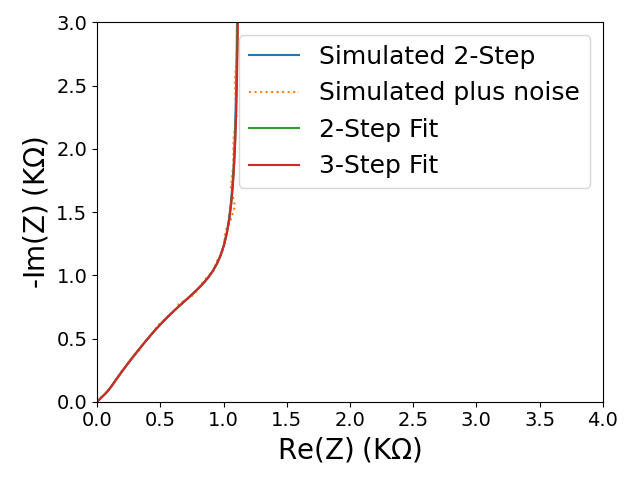

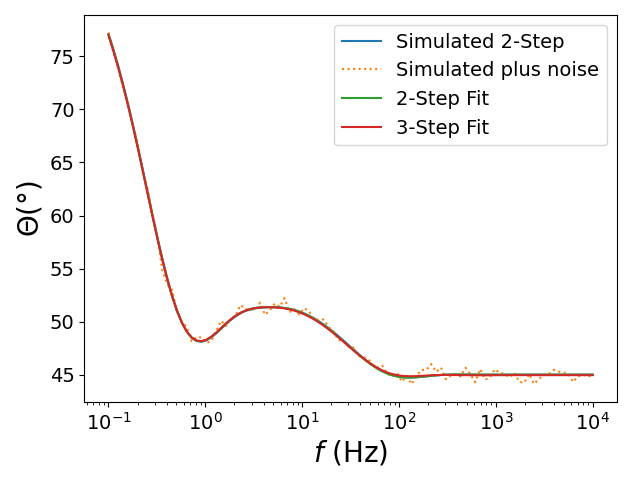

In [12]:
# fig1, ax1 =plt.subplots()
# ax1.plot(np.real(zexp),-np.imag(zexp),label="Exp data")
# ax1.plot(np.real(zexp_noise),-np.imag(zexp_noise),label="Exp data plus noise")
# ax1.plot(np.real(zfit),-np.imag(zfit),label="Fit")
# ax1.legend()
# ax1.set_aspect("equal")

fig1, ax1 =plt.subplots()
ax1.plot(np.real(zexp)/1000,-np.imag(zexp)/1000,label="Simulated 2-Step")
ax1.plot(np.real(zexp_noise)/1000,-np.imag(zexp_noise)/1000,":",label="Simulated plus noise")
ax1.plot(np.real(zfit1)/1000,-np.imag(zfit1)/1000,label="2-Step Fit")
ax1.plot(np.real(zfit2)/1000,-np.imag(zfit2)/1000,label="3-Step Fit")
ax1.legend(fontsize=18)
ax1.set_xlabel("Re(Z)$\;($K$\Omega$)",fontsize=20)
ax1.set_ylabel("-Im(Z)$\;($K$\Omega$)",fontsize=20)
ax1.tick_params(labelsize=14)
ax1.set_xlim(0,4)
ax1.set_ylim(0,3)
ax1.set_aspect("equal")
plt.tight_layout()
fig1.savefig("Nyq_2stepnoise.png",dpi=700)


fig22, ax22 = plt.subplots()
ax22.plot(freq_list,-np.angle(zexp,deg=True),label="Simulated 2-Step")
ax22.plot(freq_list,-np.angle(zexp_noise,deg=True),":",label="Simulated plus noise")
ax22.plot(freq_list,-np.angle(zfit1,deg=True),label="2-Step Fit")
ax22.plot(freq_list,-np.angle(zfit2,deg=True),label="3-Step Fit")
ax22.set_ylabel("$\Theta (\degree)$",fontsize=20)
ax22.tick_params(labelsize=14)
ax22.set_xlabel("$f$ (Hz)",fontsize=20)
ax22.legend(fontsize=14)
fig22.tight_layout()
ax22.set_xscale("log")
fig22.savefig("Bode_2stepnoise",dpi=700)

In [15]:
np.angle(1+1j,deg=True)

45.0

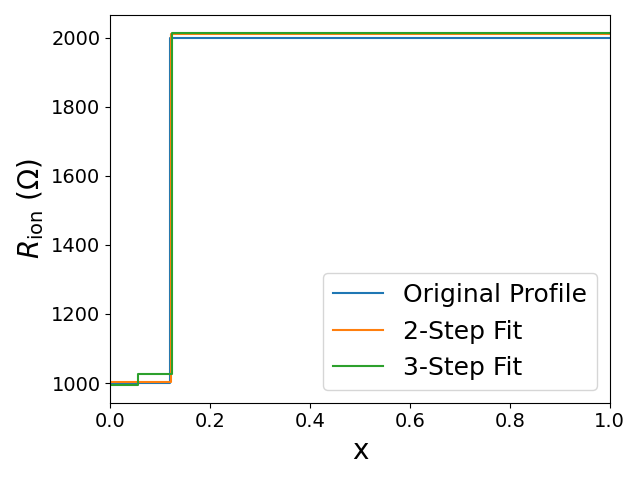

In [13]:
fig2, ax2= plt.subplots()
ax2.plot([0,delta1_dt,delta1_dt,1],[R1_dt,R1_dt,R2_dt,R2_dt],label="Original Profile")
ax2.plot([0,delta1_fit1,delta1_fit1,1],[R1_fit1,R1_fit1,R2_fit1,R2_fit1],label="2-Step Fit")
# ax2.plot([0,delta1_fit2,delta1_fit2,1],[R1_fit2,R1_fit2,R2_fit2,R2_fit2])

ax2.plot([0,delta1_fit2,delta1_fit2,delta2_fit2+delta1_fit2,delta2_fit2+delta1_fit2,1],[R1_fit2,R1_fit2,R2_fit2,R2_fit2,R3_fit2,R3_fit2],label="3-Step Fit")
ax2.legend(fontsize=18)
ax2.set_xmargin(0)
ax2.set_xlabel("x",fontsize=20)
ax2.set_ylabel("$R_{\mathrm{ion}}$ $(\Omega)$",fontsize=20)
ax2.tick_params(labelsize=14)
plt.tight_layout()
fig2.savefig("2stepnoise.png",dpi=700)